In [1]:
import os, time, itertools, sys
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp
from copy import deepcopy
from pybaseball import *
sys.path.append('/home/dcooper/rockies/RockiesAnalysis/')
from utils.plotting.spray_chart import *

/home/dcooper/anaconda3/envs/rockies/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Get batted ball data

In [2]:
# Load/build database
if not os.path.exists('../data/2020-2025_allBattedBallData.csv'):
    dfs = []
    for year in range(2020, 2026):
        print(f"Pulling {year}...")
        try:
            df = statcast(
                start_dt=f"{year}-03-01",
                end_dt=f"{year}-10-01",
                verbose=False
            )
            # Keep only balls in play
            df = df[df['type'] == 'X']
            dfs.append(df)
            time.sleep(5)  # be nice to Savant
        except Exception as e:
            print(f"Failed for {year}: {e}")
    
    all_bb_data = pd.concat(dfs, ignore_index=True)
    all_bb_data.to_csv('../data/2020-2025_allBattedBallData.csv')
else:
    all_bb_data = pd.read_csv('../data/2020-2025_allBattedBallData.csv', index_col=0)

# Filter to regular season games
all_bb_data = all_bb_data.loc[all_bb_data['game_type'] == 'R']

# Display dataframe
print(all_bb_data.shape)
all_bb_data.head()

(658753, 118)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
773,FF,2020-09-27,91.6,2.31,6.19,"Hand, Brad",605137,543272,field_out,hit_into_play,...,NaN,1.38,0.86,-0.86,35.1,NaN,NaN,NaN,NaN,NaN
774,FF,2020-09-27,92.8,2.39,6.27,"Hand, Brad",663647,543272,field_out,hit_into_play,...,NaN,1.25,0.92,-0.92,36.2,NaN,NaN,NaN,NaN,NaN
775,SI,2020-09-27,96.7,-2.20,5.92,"Cederlind, Blake",596019,664977,field_out,hit_into_play,...,2.0,1.92,1.44,-1.44,35.1,NaN,NaN,NaN,NaN,NaN
776,SI,2020-09-27,98.0,-2.19,5.94,"Cederlind, Blake",640458,664977,field_out,hit_into_play,...,3.0,1.82,1.38,1.38,34.1,NaN,NaN,NaN,NaN,NaN
777,FF,2020-09-27,91.3,2.59,5.99,"Hand, Brad",624428,543272,field_out,hit_into_play,...,NaN,1.37,1.09,1.09,27.2,NaN,NaN,NaN,NaN,NaN


In [3]:
# Set bins
ev_labels = np.array(['<80', '80-85', '85-90', '90-95', '95-100', '100-105', '105-110', '>=110'])
ev_bins = np.array([0,80,85,90,95,100,105,110,999])
la_labels = np.array(['<10°', '10-25°', '25-35°', '35-50°', '>=50°'])
la_bins = np.array([-999, 10, 25, 35, 50, 999])
sa_labels = np.array(['-45 to -27°', '-27 to -9°', '-9 to 9°', '9 to 27°', '27 to 45°'])
sa_bins = np.array([-999, -27,  -9,  9,  27, 999])

# Add spray angle column
all_bb_data.insert(0, 'spray_angle', value=np.degrees(np.arctan2(all_bb_data['hc_x'] - 125, 199 - all_bb_data['hc_y'])), allow_duplicates=False)

# Add bin columns 
all_bb_data.insert(0, 'launch_speed_bin', value='', allow_duplicates=False)
all_bb_data.insert(0, 'launch_angle_bin', value='', allow_duplicates=False)
all_bb_data.insert(0, 'spray_angle_bin', value='', allow_duplicates=False)

# Reorder columns
tgt_cols = ['launch_speed', 'launch_speed_bin', 'launch_angle', 'launch_angle_bin', 'spray_angle', 'spray_angle_bin', 'events', 'home_team', 'hc_x', 'hc_y', 'stand', 'batter', 'game_year'] 
df = all_bb_data[tgt_cols]

# Add data to new columns
df.loc[:,'launch_speed_bin'] = pd.cut(df['launch_speed'], ev_bins, labels=ev_labels, right=False)
df.loc[:,'launch_angle_bin'] = pd.cut(df['launch_angle'], la_bins, labels=la_labels, right=False)
df.loc[:,'spray_angle_bin'] = pd.cut(df['spray_angle'], sa_bins, labels=sa_labels, right=False)

df.head()

,launch_speed,launch_speed_bin,launch_angle,launch_angle_bin,spray_angle,spray_angle_bin,events,home_team,hc_x,hc_y,stand,batter,game_year
773,88.4,85-90,32.0,25-35°,43.763679,27 to 45°,field_out,CLE,217.94,101.96,R,605137,2020
774,102.0,100-105,41.0,35-50°,-5.926369,-9 to 9°,field_out,CLE,108.85,43.42,R,663647,2020
775,100.5,100-105,-20.0,<10°,24.128726,9 to 27°,field_out,CLE,152.61,137.36,L,596019,2020
776,84.1,80-85,22.0,10-25°,-19.733931,-27 to -9°,field_out,CLE,81.95,78.99,R,640458,2020
777,88.7,85-90,17.0,10-25°,-26.614826,-27 to -9°,field_out,CLE,76.57,102.35,L,624428,2020


In [4]:
# Build expected outcomes table
exp_outcomes = pd.DataFrame(columns=['EV', 'LA', 'SA', 'ΔHR', 'Δ3B', 'Δ2B', 'Δ1B', 'ΔOut', 'Bases_nCoors', 'Bases_Coors', 'n_Coors'])

# Check for valid events
valid_events = [
    'home_run', 'triple', 'double', 'single',
    'field_out', 'sac_fly', 'force_out',
    'double_play', 'grounded_into_double_play',
    'fielders_choice_out', 'fielders_choice',
    'triple_play', 'sac_fly_double_play'
]
df = df.loc[df['events'].isin(valid_events)]

# Iterate through bin type combinations
for ev_bin, la_bin, sa_bin in itertools.product(ev_labels, la_labels, sa_labels):

    # Filter by bin types
    bin_df = df.loc[df['launch_speed_bin'] == ev_bin]
    bin_df = bin_df.loc[bin_df['launch_angle_bin'] == la_bin]
    bin_df = bin_df.loc[bin_df['spray_angle_bin'] == sa_bin]

    # Split by location
    c_bin_df = bin_df.loc[bin_df['home_team'] == 'COL']
    nc_bin_df = bin_df.loc[bin_df['home_team'] != 'COL']

    # Iterate through outcomes and compute deltas for hits
    nc = []
    c = []
    deltas = []
    for event in ['home_run', 'triple', 'double', 'single', 'out']:

        # Get event occurance
        if event == 'out':
            nc_n_event = nc_bin_df.loc[nc_bin_df['events'].isin(['field_out', 'sac_fly', 'force_out', 'double_play', 'grounded_into_double_play', 'fielders_choice_out', 'fielders_choice', 'triple_play', 'sac_fly_double_play'])].shape[0]
            c_n_event = c_bin_df.loc[c_bin_df['events'].isin(['field_out', 'sac_fly', 'force_out', 'double_play', 'grounded_into_double_play', 'fielders_choice_out', 'fielders_choice', 'triple_play', 'sac_fly_double_play'])].shape[0]
        else:
            nc_n_event = nc_bin_df.loc[nc_bin_df['events'] == event].shape[0]
            c_n_event = c_bin_df.loc[c_bin_df['events'] == event].shape[0]

        # Convert to probabilities
        try:
            nc_p_event = nc_n_event / nc_bin_df.shape[0]
            c_p_event = c_n_event / c_bin_df.shape[0]
        except ZeroDivisionError:
            deltas.append(np.nan)
            nc.append(np.nan)
            c.append(np.nan)
            continue

        # Compute delta probabilities
        d_p_event = c_p_event - nc_p_event
        deltas.append(d_p_event)
        nc.append(nc_p_event)
        c.append(c_p_event)

    nc_bases = 4 * nc[0] + 3 * nc[1] + 2 * nc[2] + nc[1]
    c_bases = 4 * c[0] + 3 * c[1] + 2 * c[2] + c[1]
    exp_outcomes.loc[exp_outcomes.shape[0]] = [ev_bin, la_bin, sa_bin]  + deltas + [nc_bases, c_bases] + [c_bin_df.shape[0]]

# Drop NA
exp_outcomes.dropna(inplace=True)

# Drop anywhere n_Coors < 50
exp_outcomes = exp_outcomes.loc[exp_outcomes['n_Coors'] >= 50]

# Add delta bases
d_bases = 4 * exp_outcomes['ΔHR'] + 3 * exp_outcomes['Δ3B'] + 2 * exp_outcomes['Δ2B'] + exp_outcomes['Δ1B']
exp_outcomes.insert(10, 'ΔBases', d_bases)

# Round 
exp_outcomes = exp_outcomes.round(2)

In [5]:
players = [
    ['Beck', 'Jordan'],
    ['Goodman', 'Hunter'],
    ['Doyle', 'Brenton'],
    ['Moniak', 'Mickey'],
    ['Freeman', 'Tyler'],
    ['McMahon', 'Ryan'],
    ['Tovar', 'Ezequiel'],
    ['Toglia', 'Michael'],
    ['Farmer', 'Kyle'],
    ['Ritter', 'Ryan'],
    ['Arcia', 'Orlando'],
    ['Estrada', 'Thairo'],
    ['Karros', 'Kyle'],
    ['Fernandez', 'Yanquiel'],
    ['Bernabel', 'Warming'],
    ['Amador', 'Adael'],
    ['Fulford', 'Braxton'],
    ['Martini', 'Nick']
]

In [6]:
def get_player_dfs(last_name=None, first_name=None, player_id=None, year=2025, home_team='COL'):
    if player_id is None:
        player_id = playerid_lookup(last_name, first_name, ignore_accents=True)['key_mlbam'][0]

    player_df = df.loc[df['batter'] == player_id]
    if year is not None:
        player_df = player_df.loc[player_df['game_year'] == year]
    if home_team is not None:
        player_df = player_df.loc[player_df['home_team'] == home_team]
    assert player_df.shape[0] > 0

    print(f'Found {player_df.shape[0]} batted balls for {first_name} {last_name}')

    player_contact = pd.DataFrame(columns=['EV', 'LA', 'SA', 'count', 'ΔHR', 'Δ3B', 'Δ2B', 'Δ1B', 'ΔOut', 'ΔBases'])
    for i, ev_label in enumerate(ev_labels):
        for j, la_label in enumerate(la_labels):
            for k, sa_label in enumerate(sa_labels):
                count = player_df.loc[player_df['launch_speed_bin'] == ev_label].loc[player_df['launch_angle_bin'] == la_label].loc[player_df['spray_angle_bin'] == sa_label].shape[0]
                dO_L = exp_outcomes.loc[exp_outcomes['EV'] == ev_label].loc[exp_outcomes['LA'] == la_label].loc[exp_outcomes['SA'] == sa_label]
                if dO_L.shape[0] > 0:
                    dO_L = dO_L[['ΔHR', 'Δ3B', 'Δ2B', 'Δ1B', 'ΔOut', 'ΔBases']].to_numpy()[0]                
                else:
                    dO_L = np.zeros(6)  
                player_contact.loc[player_contact.shape[0]] = [ev_label, la_label, sa_label, count] + list(dO_L * count)

    player_contact = player_contact.sort_values('ΔBases', ascending=False)
    player_contact = player_contact.reset_index(drop=True)

    return player_contact, player_df

In [7]:
player_contacts = []
bb_dfs = []
for last_name, first_name in players:
    player_contact, bb_df = get_player_dfs(last_name, first_name, home_team='COL')
    player_contacts.append(player_contact)
    bb_dfs.append(bb_df)

Gathering player lookup table. This may take a moment.
Found 209 batted balls for Jordan Beck
Found 204 batted balls for Hunter Goodman
Found 191 batted balls for Brenton Doyle
Found 180 batted balls for Mickey Moniak
Found 185 batted balls for Tyler Freeman
Found 114 batted balls for Ryan McMahon
Found 130 batted balls for Ezequiel Tovar
Found 91 batted balls for Michael Toglia
Found 97 batted balls for Kyle Farmer
Found 82 batted balls for Ryan Ritter
Found 66 batted balls for Orlando Arcia
Found 71 batted balls for Thairo Estrada
Found 39 batted balls for Kyle Karros
Found 53 batted balls for Yanquiel Fernandez
Found 52 batted balls for Warming Bernabel
Found 48 batted balls for Adael Amador
Found 37 batted balls for Braxton Fulford
Found 38 batted balls for Nick Martini


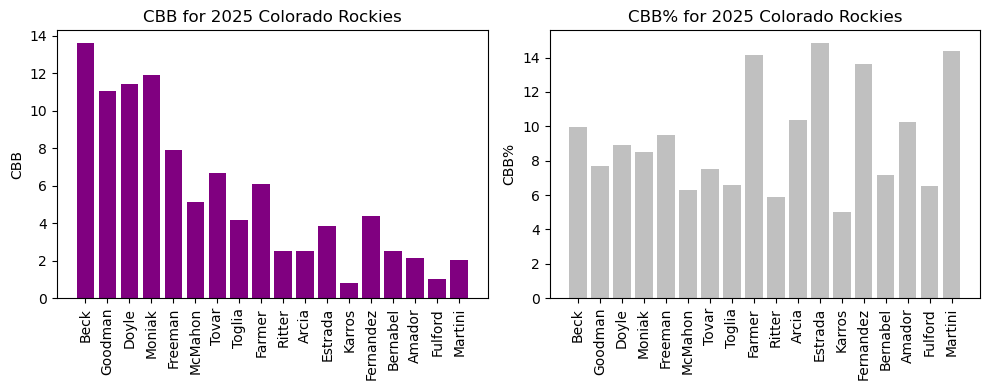

99.67


In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

"""
contact_df is Coors-only
bb_df is all batted ball data
"""
CBB_sum = 0
for i, ((last_name, first_name), contact_df, bb_df) in enumerate(zip(players, player_contacts, bb_dfs)):
    hr = bb_df.loc[bb_df['events'] == 'home_run'].shape[0]
    triple = bb_df.loc[bb_df['events'] == 'triple'].shape[0]
    double = bb_df.loc[bb_df['events'] == 'double'].shape[0]
    single = bb_df.loc[bb_df['events'] == 'single'].shape[0]
    player_bases = 4*hr + 3*triple + 2*double + single

    coors_boosted_bases = contact_df['ΔBases'].sum(axis=0)
    coors_boosted_bases_perc = 100 * coors_boosted_bases / player_bases 

    CBB_sum += coors_boosted_bases    
    # axs[0].bar(i, player_bases, color='')
    # axs[0].bar(i, coors_boosted_bases, bottom=player_bases-coors_boosted_bases, color='silver')
    axs[0].bar(i, coors_boosted_bases, color='purple')
    axs[0].set_title('CBB for 2025 Colorado Rockies')

    
    # axs[1].bar(i, 100, color='purple')
    # axs[1].bar(i, coors_boosted_bases_perc, bottom=100-coors_boosted_bases_perc, color='silver')
    axs[1].bar(i, coors_boosted_bases_perc, color='silver')
    axs[1].set_title('CBB% for 2025 Colorado Rockies')


for ax in axs:
    ax.set_xticks(np.arange(len(players)), [f'{last_name}' for last_name, first_name in players], rotation=90)

axs[0].set_ylabel('CBB')
axs[1].set_ylabel('CBB%')
fig.tight_layout()
plt.show()
print(CBB_sum)

In [9]:
last_season_df = all_bb_data.loc[all_bb_data['game_year'] == 2025]
batter_ids, counts = np.unique(last_season_df['batter'].to_numpy(), return_counts=True)
batter_ids = batter_ids[counts >= 100]
all_players_CBB = pd.DataFrame(columns=['first', 'last', 'ΔHR', 'Δ3B', 'Δ2B', 'Δ1B', 'ΔOut', 'CBB', 'CBB%'])
for batter_id in batter_ids:
    batter_CBB, batter_bb = get_player_dfs(player_id=batter_id, home_team=None)
    if batter_CBB['count'].sum() >= 100:
        CBB = batter_CBB['ΔBases'].sum(axis=0) / 2
        hr = batter_bb.loc[batter_bb['events'] == 'home_run'].shape[0]
        triple = batter_bb.loc[batter_bb['events'] == 'triple'].shape[0]
        double = batter_bb.loc[batter_bb['events'] == 'double'].shape[0]
        single = batter_bb.loc[batter_bb['events'] == 'single'].shape[0]
        player_bases = 4*hr + 3*triple + 2*double + single
        CBB_perc = 100 * (CBB / (player_bases / 2))
        
        all_players_CBB.loc[all_players_CBB.shape[0]] = playerid_reverse_lookup([batter_id])[['name_first', 'name_last']].iloc[0].to_list() + (batter_CBB[['ΔHR', 'Δ3B', 'Δ2B', 'Δ1B', 'ΔOut', 'ΔBases']].sum(axis=0) / 2).to_list() + [CBB_perc]

Found 127 batted balls for None None
Found 361 batted balls for None None
Found 135 batted balls for None None
Found 326 batted balls for None None
Found 243 batted balls for None None
Found 298 batted balls for None None
Found 387 batted balls for None None
Found 481 batted balls for None None
Found 228 batted balls for None None
Found 140 batted balls for None None
Found 430 batted balls for None None
Found 152 batted balls for None None
Found 471 batted balls for None None
Found 330 batted balls for None None
Found 346 batted balls for None None
Found 231 batted balls for None None
Found 383 batted balls for None None
Found 389 batted balls for None None
Found 154 batted balls for None None
Found 101 batted balls for None None
Found 212 batted balls for None None
Found 284 batted balls for None None
Found 382 batted balls for None None
Found 181 batted balls for None None
Found 394 batted balls for None None
Found 141 batted balls for None None
Found 352 batted balls for None None
F

## pCBB

In [10]:
batted_ball_events = ['double', 'field_error', 'field_out', 'fielders_choice_out', 'force_out', 'grounded_into_double_play', 'home_run', 'sac_fly', 'single', 'triple']

pCBBs = np.zeros(all_players_CBB.shape[0])
for i, r in all_players_CBB.iterrows():
    waiting = True
    while waiting:
        try:
            player_id = playerid_lookup(r['last'], r['first'], ignore_accents=True)['key_mlbam'][0]
            player_data = statcast_batter(start_dt='2025-03-27', end_dt='2025-09-28', player_id=player_id)
            waiting = False
        except:
            pass
    player_events = player_data['events'].dropna().to_numpy()
    try:
        plate_appearances = len(player_events[player_events != 'truncated_pa'])
        if plate_appearances < 50:
            continue
        walks, strikeouts = len(player_events[player_events == 'walk']), len(player_events[player_events == 'strikeout'])
        
        batted_ball_perc = 100 * (plate_appearances - (walks + strikeouts)) / plate_appearances
        pCBBs[i] = (r['CBB%'] * batted_ball_perc * 251) / 10000
    except ZeroDivisionError:
        pCBBs[i] = np.nan
        

all_players_CBB['pCBB'] = pCBBs 
all_players_CBB.head()

Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering 

,first,last,ΔHR,Δ3B,Δ2B,Δ1B,ΔOut,CBB,CBB%,pCBB
0,donovan,solano,0.425,0.310,0.715,0.260,-1.710,4.270,15.250000,28.013142
1,andrew,mccutchen,0.980,0.980,1.655,0.580,-4.120,10.445,11.937143,20.228583
2,justin,turner,0.135,0.495,0.835,0.570,-1.970,4.060,15.320755,27.671391
3,carlos,santana,0.040,0.770,1.420,2.015,-4.160,7.090,10.503704,18.466132
4,miguel,rojas,0.270,0.525,0.545,0.750,-2.055,4.310,7.495652,14.795544


In [11]:
styled_df = all_players_CBB.sort_values('pCBB', ascending=False)[['first', 'last', 'CBB', 'CBB%', 'pCBB']].head(20).round(2)
styled_df = styled_df.style.format({
        'CBB': '{:.2f}',
        'CBB%': '{:.2f}',
        'pCBB': '{:.2f}'
    }).background_gradient(
    cmap='bwr',
    vmin=0,
    vmax=styled_df['pCBB'].max(),
    subset=['pCBB']
).background_gradient(
    cmap='bwr',
    vmin=0,
    vmax=styled_df['CBB%'].max(),
    subset=['CBB%']
).background_gradient(
    cmap='bwr',
    vmin=0,
    vmax=styled_df['CBB'].max(),
    subset=['CBB']
)
styled_df

,first,last,CBB,CBB%,pCBB
320,michael,massey,6.92,16.87,34.39
76,jose,trevino,7.98,16.11,33.21
331,graham,pauley,5.40,18.32,31.74
373,cole,young,5.81,17.09,30.54
203,josh,rojas,4.33,17.67,30.27
210,tommy,edman,9.80,14.86,29.47
64,luis,torrens,7.12,15.81,29.17
224,miles,mastrobuoni,3.47,15.44,28.58
379,chase,meidroth,10.52,14.60,28.24
18,christian,vazquez,3.89,14.94,28.22


## Analyze Michael Massey

In [12]:
contact_df, bb_df = get_player_dfs('Massey', 'Michael', home_team=None)

Found 222 batted balls for Michael Massey


In [16]:
contact_df.sort_values('ΔBases', ascending=False)

,EV,LA,SA,count,ΔHR,Δ3B,Δ2B,Δ1B,ΔOut,ΔBases
0,95-100,25-35°,-45 to -27°,2,0.52,0.00,-0.04,-0.02,-0.46,1.98
1,95-100,25-35°,9 to 27°,2,0.12,0.06,0.44,-0.02,-0.62,1.54
2,95-100,35-50°,27 to 45°,3,0.18,0.21,-0.06,-0.00,-0.30,1.17
3,95-100,<10°,27 to 45°,10,0.00,0.10,-0.10,1.00,-0.90,0.90
4,95-100,35-50°,9 to 27°,3,0.09,0.09,0.06,-0.00,-0.21,0.72
5,100-105,25-35°,9 to 27°,1,0.12,0.03,0.06,-0.00,-0.21,0.67
6,90-95,25-35°,27 to 45°,2,-0.04,0.06,0.28,0.02,-0.32,0.58
7,95-100,10-25°,-27 to -9°,5,-0.05,0.15,0.15,-0.00,-0.20,0.55
8,100-105,<10°,27 to 45°,10,-0.00,0.00,0.10,0.20,-0.40,0.50
9,95-100,25-35°,-9 to 9°,3,0.00,0.12,0.03,-0.00,-0.15,0.42


In [14]:
bb_df.head()

,launch_speed,launch_speed_bin,launch_angle,launch_angle_bin,spray_angle,spray_angle_bin,events,home_team,hc_x,hc_y,stand,batter,game_year
576718,93.2,90-95,26.0,25-35°,46.275247,27 to 45°,double,ATH,218.91,109.18,L,686681,2025
576745,87.2,85-90,13.0,10-25°,-13.757980,-27 to -9°,single,ATH,98.04,88.89,L,686681,2025
576755,103.5,100-105,4.0,<10°,39.599404,27 to 45°,single,ATH,198.94,109.62,L,686681,2025
576762,103.4,100-105,21.0,10-25°,32.948962,27 to 45°,single,ATH,201.39,81.14,L,686681,2025
577379,87.0,85-90,61.0,>=50°,-38.853781,-45 to -27°,field_out,ATH,67.70,127.87,L,686681,2025


In [26]:
exp_outcomes.head()

,EV,LA,SA,ΔHR,Δ3B,Δ2B,Δ1B,ΔOut,Bases_nCoors,Bases_Coors,ΔBases,n_Coors
0,<80,<10°,-45 to -27°,0.0,-0.0,-0.01,0.03,-0.03,0.04,0.03,0.02,819
1,<80,<10°,-27 to -9°,0.0,0.0,-0.00,-0.01,0.01,0.00,0.00,-0.01,669
2,<80,<10°,-9 to 9°,0.0,0.0,-0.00,0.01,-0.00,0.00,0.00,0.00,377
3,<80,<10°,9 to 27°,0.0,0.0,0.00,0.01,-0.01,0.00,0.00,0.01,520
4,<80,<10°,27 to 45°,0.0,-0.0,0.00,0.01,-0.01,0.02,0.02,0.01,858


In [62]:
styled_df = contact_df.sort_values('ΔBases', ascending=False).head(15)
styled_df = styled_df.style.background_gradient(
    cmap='bwr', 
    vmin=-1, 
    vmax=1, 
    subset=['ΔHR', 'Δ3B', 'Δ2B', 'Δ1B', 'ΔOut', 'ΔBases']
).set_caption('Michael Massey ΔBases at Coors Field')
styled_df

,EV,LA,SA,count,ΔHR,Δ3B,Δ2B,Δ1B,ΔOut,ΔBases
0,95-100,25-35°,-45 to -27°,2,0.520000,0.000000,-0.040000,-0.020000,-0.460000,1.980000
1,95-100,25-35°,9 to 27°,2,0.120000,0.060000,0.440000,-0.020000,-0.620000,1.540000
2,95-100,35-50°,27 to 45°,3,0.180000,0.210000,-0.060000,-0.000000,-0.300000,1.170000
3,95-100,<10°,27 to 45°,10,0.000000,0.100000,-0.100000,1.000000,-0.900000,0.900000
4,95-100,35-50°,9 to 27°,3,0.090000,0.090000,0.060000,-0.000000,-0.210000,0.720000
5,100-105,25-35°,9 to 27°,1,0.120000,0.030000,0.060000,-0.000000,-0.210000,0.670000
6,90-95,25-35°,27 to 45°,2,-0.040000,0.060000,0.280000,0.020000,-0.320000,0.580000
7,95-100,10-25°,-27 to -9°,5,-0.050000,0.150000,0.150000,-0.000000,-0.200000,0.550000
8,100-105,<10°,27 to 45°,10,-0.000000,0.000000,0.100000,0.200000,-0.400000,0.500000
9,95-100,25-35°,-9 to 9°,3,0.000000,0.120000,0.030000,-0.000000,-0.150000,0.420000


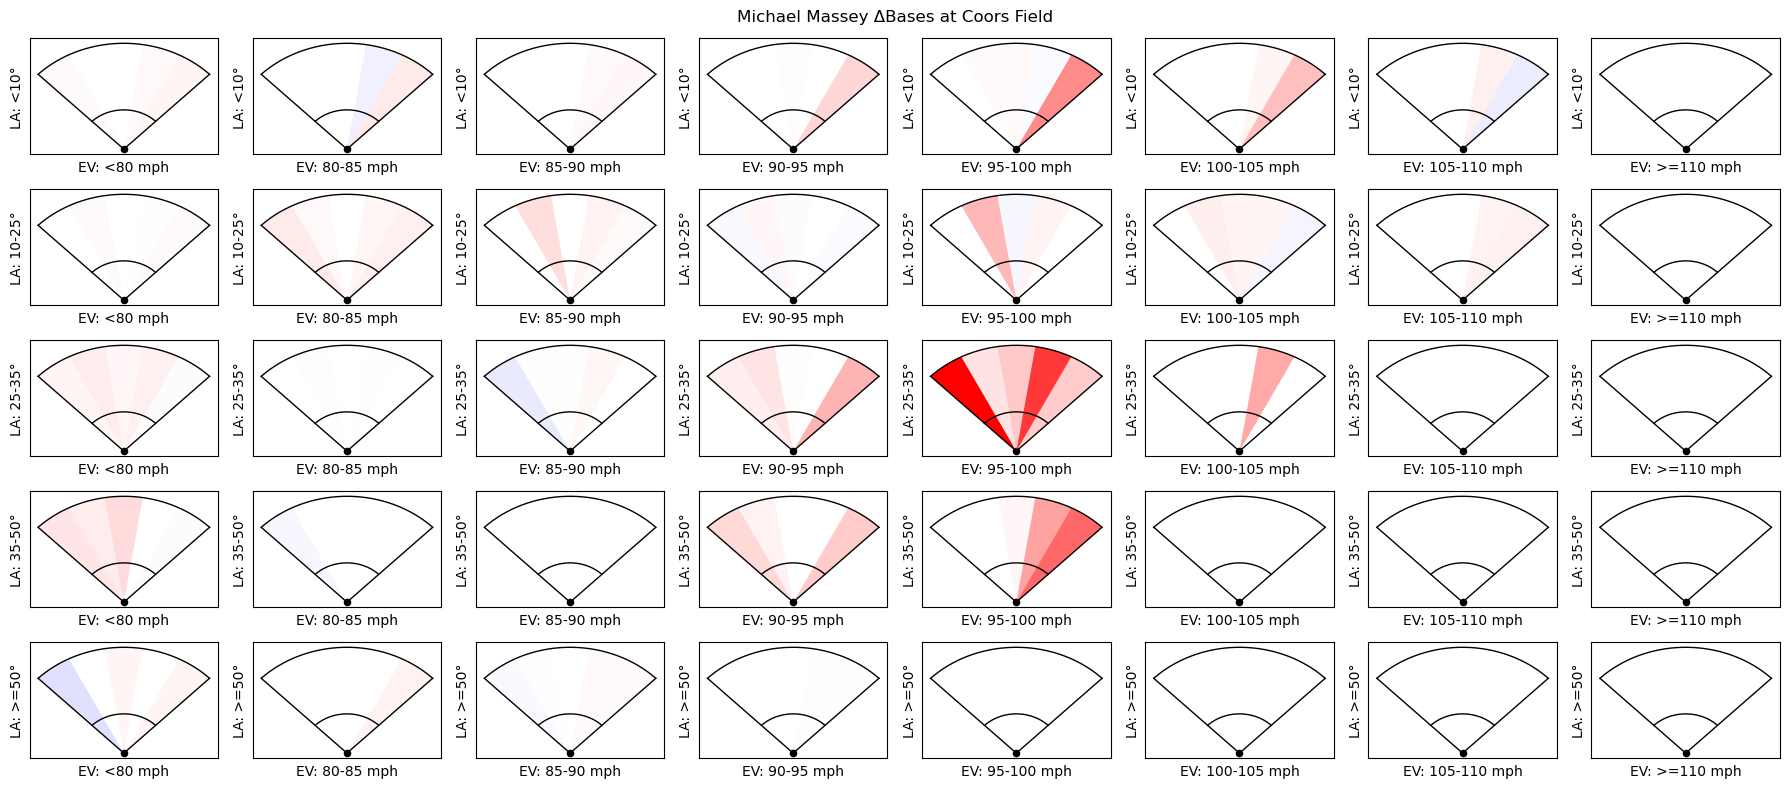

In [58]:
fig, axs = plt.subplots(5, 8, figsize=(18,8))

for i, ev_label in enumerate(ev_labels):
    for j, la_label in enumerate(la_labels):

        # General Plot
        ax = axs[j,i]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel(f'LA: {la_label}')
        ax.set_xlabel(f'EV: {ev_label} mph')

        # Get subset
        sub_df = contact_df.loc[contact_df['EV'] == ev_label].loc[contact_df['LA'] == la_label]
        if sub_df.shape[0] == 0:
            ax.axis('off')
            continue
        else:
            draw_field(ax)

        # Add wedges
        for k, r in sub_df.iterrows():
            range = (int(r['SA'].split()[0]), int(r['SA'].split()[-1][:-1]))
            ax = draw_wedge(ax, range, val=r['ΔBases'], norm_factor=max(np.abs(contact_df['ΔBases']).max(), 1))
            
fig.suptitle('Michael Massey ΔBases at Coors Field')
fig.tight_layout()
plt.show()